# Capstone Project: OTC Medication Sales EDA and Forecasting

This notebook explores over-the-counter (OTC) medication sales data with the goal of detecting anomalies (spikes and drops) and building a predictive model to assist inventory planning and public health monitoring.


## 1. Import Libraries

Importing necessary libraries for data processing, visualization, statistical testing, and modeling.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

## 2. Load Dataset 

Loaded the OTC sales dataset

In [58]:
df = pd.read_csv("data/pharmacy_otc_sales_data.csv", parse_dates=['Date'])
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Outlier detection using IQR
Q1 = weekly_df['Boxes Shipped'].quantile(0.25)
Q3 = weekly_df['Boxes Shipped'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = weekly_df[(weekly_df['Boxes Shipped'] < lower_bound) | (weekly_df['Boxes Shipped'] > upper_bound)]

print(outliers)

Empty DataFrame
Columns: [Week, Boxes Shipped]
Index: []


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           333 non-null    datetime64[ns]
 1   Product        333 non-null    object        
 2   Sales Person   333 non-null    object        
 3   Boxes Shipped  333 non-null    int64         
 4   Amount ($)     333 non-null    float64       
 5   Country        333 non-null    object        
 6   Week           333 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 18.3+ KB


In [62]:
df.describe()

,Date,Boxes Shipped,Amount ($),Week
count,333,333.000000,333.000000,333
mean,2022-05-07 19:31:53.513513472,10.474474,176.964835,2022-05-04 17:04:51.891891968
min,2022-01-02 00:00:00,1.000000,8.090000,2021-12-27 00:00:00
25%,2022-03-09 00:00:00,5.000000,75.990000,2022-03-07 00:00:00
50%,2022-05-17 00:00:00,11.000000,156.920000,2022-05-16 00:00:00
75%,2022-07-06 00:00:00,16.000000,248.770000,2022-07-04 00:00:00
max,2022-08-31 00:00:00,20.000000,494.080000,2022-08-29 00:00:00
std,NaN,5.955415,119.058556,NaN


In [64]:
#First few rows
df.head()

,Date,Product,Sales Person,Boxes Shipped,Amount ($),Country,Week
0,2022-02-06,Pain Relief Tablets,Divya Mehra,7,67.43,Australia,2022-01-31
1,2022-02-05,Antiseptic Cream,Nikhil Batra,18,421.46,Canada,2022-01-31
2,2022-02-19,Cough Syrup,Ritika Shah,2,48.25,UK,2022-02-14
3,2022-03-28,Pain Relief Tablets,Nikhil Batra,5,59.89,UK,2022-03-28
4,2022-01-17,Digestive Enzyme,Ritika Shah,8,147.73,USA,2022-01-17


In [66]:
# Check null values
print("\nNull values in dataset:", df.isnull().sum())


Null values in dataset: Date             0
Product          0
Sales Person     0
Boxes Shipped    0
Amount ($)       0
Country          0
Week             0
dtype: int64


## 3. Exploratory Data Analysis (EDA)
Converted date values, and aggregated weekly sales for modeling.



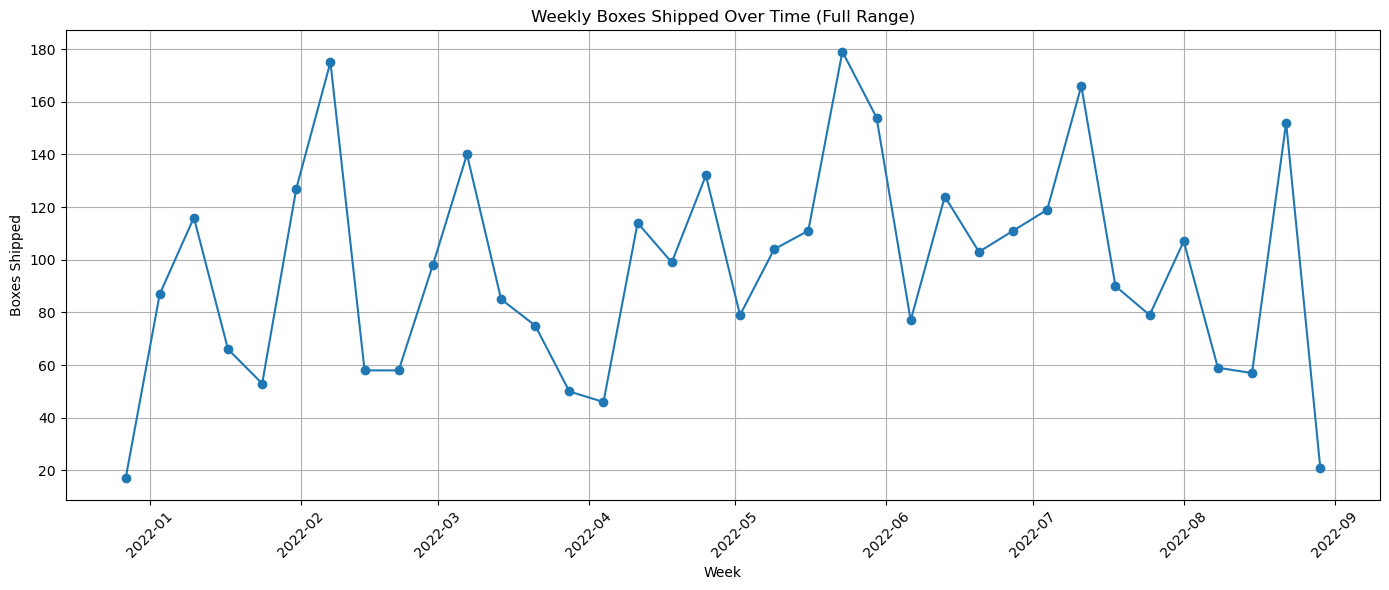

In [69]:
weekly_df = df.groupby('Week').agg({'Boxes Shipped': 'sum'}).reset_index()

plt.figure(figsize=(14, 6))
plt.plot(weekly_df['Week'], weekly_df['Boxes Shipped'], marker='o', linestyle='-')
plt.title('Weekly Boxes Shipped Over Time (Full Range)')
plt.xlabel('Week')
plt.ylabel('Boxes Shipped')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

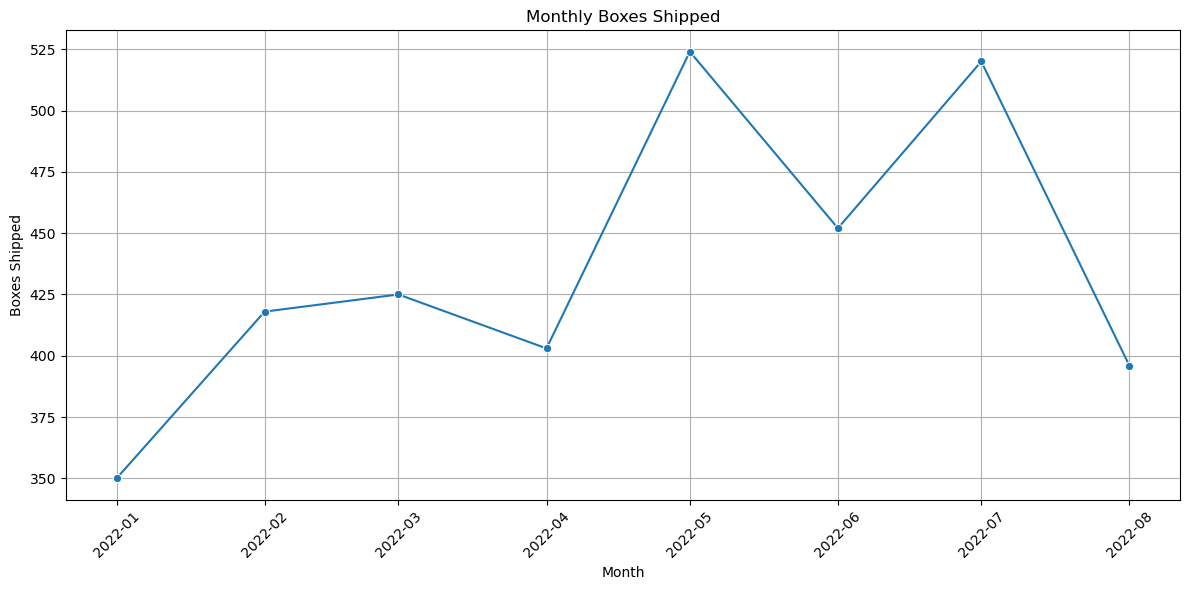

In [71]:
# Monthly analysis
monthly_df = df.groupby(df['Date'].dt.to_period('M')).agg({'Boxes Shipped':'sum'}).reset_index()
monthly_df['Date'] = monthly_df['Date'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Boxes Shipped', data=monthly_df, marker='o')
plt.title('Monthly Boxes Shipped')
plt.xlabel('Month')
plt.ylabel('Boxes Shipped')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4 Statistical Analysis with `scipy.stats`

Used statistical tests to examine distribution characteristics of the sales data, including skewness and normality.


In [74]:
stat, p = stats.shapiro(weekly_df['Boxes Shipped'])
skewness = stats.skew(weekly_df['Boxes Shipped'])
print(f"Shapiro-Wilk Test Statistic: {stat:.3f}, p-value: {p:.3f}")
print(f"Data Skewness: {skewness:.2f}")

Shapiro-Wilk Test Statistic: 0.982, p-value: 0.809
Data Skewness: 0.15


## 5. Model Building: Random Forest

Trained a Random Forest Regressor to predict weekly OTC sales. Evaluated performance using R² score and mean squared error.



In [77]:
# Preparing Data for Modeling
weekly_df['Time_Index'] = np.arange(len(weekly_df)).reshape(-1, 1)
weekly_df['lag_1'] = weekly_df['Boxes Shipped'].shift(1)
weekly_df['lag_2'] = weekly_df['Boxes Shipped'].shift(2)
weekly_df['lag_3'] = weekly_df['Boxes Shipped'].shift(3)
weekly_df['rolling_mean_3'] = weekly_df['Boxes Shipped'].rolling(window=3).mean()
weekly_df['weekofyear'] = weekly_df['Week'].dt.isocalendar().week
weekly_df['month'] = weekly_df['Week'].dt.month
weekly_df.dropna(inplace=True)

In [79]:
#  Baseline Model: Random Forest with only time index as feature
X_base = weekly_df[['Time_Index']]
y = weekly_df['Boxes Shipped']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y, test_size=0.2, shuffle=False)
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train_base, y_train_base)
y_pred_base = rf_base.predict(X_test_base)


# Evaluate baseline model
r2_base = r2_score(y_test_base, y_pred_base)
mse_base = mean_squared_error(y_test_base, y_pred_base)

# Enhanced Model: Random Forest with lag and calendar features
features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'weekofyear', 'month']
X_enhanced = weekly_df[features]
y_enhanced = weekly_df['Boxes Shipped']

X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(X_enhanced, y_enhanced, test_size=0.2, shuffle=False)
rf_enh = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_enh.fit(X_train_enh, y_train_enh)
y_pred_enh = rf_enh.predict(X_test_enh)

# Evaluate enhanced model
r2_enh = r2_score(y_test_enh, y_pred_enh)
mse_enh = mean_squared_error(y_test_enh, y_pred_enh)

# Model Comparison
model_comparison = pd.DataFrame({
    'Model': ['Baseline RF (Time Index)', 'Enhanced RF (Lag + Calendar Features)'],
    'R2 Score': [r2_base, r2_enh],
    'Mean Squared Error': [mse_base, mse_enh]
})


In [80]:
# Model Evaluation
print(model_comparison)

                                   Model  R2 Score  Mean Squared Error
0               Baseline RF (Time Index) -3.015882         6001.693929
1  Enhanced RF (Lag + Calendar Features) -0.422120         2125.343178


## 6. Visualization of Predictions

Compared predicted sales to actual values using a line plot to assess model accuracy visually.


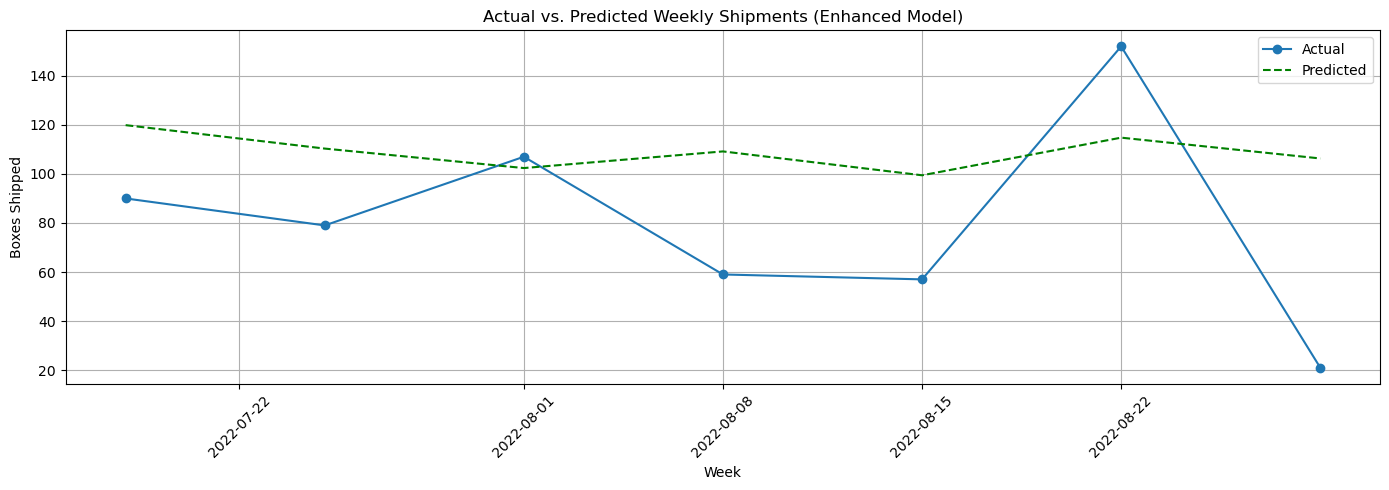

In [84]:
plt.figure(figsize=(14, 5))
plt.plot(weekly_df['Week'].iloc[-len(y_test_enh):], y_test_enh, label='Actual', marker='o')
plt.plot(weekly_df['Week'].iloc[-len(y_test_enh):], y_pred_enh, label='Predicted', linestyle='--', color='green')
plt.xlabel('Week')
plt.ylabel('Boxes Shipped')
plt.title('Actual vs. Predicted Weekly Shipments (Enhanced Model)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

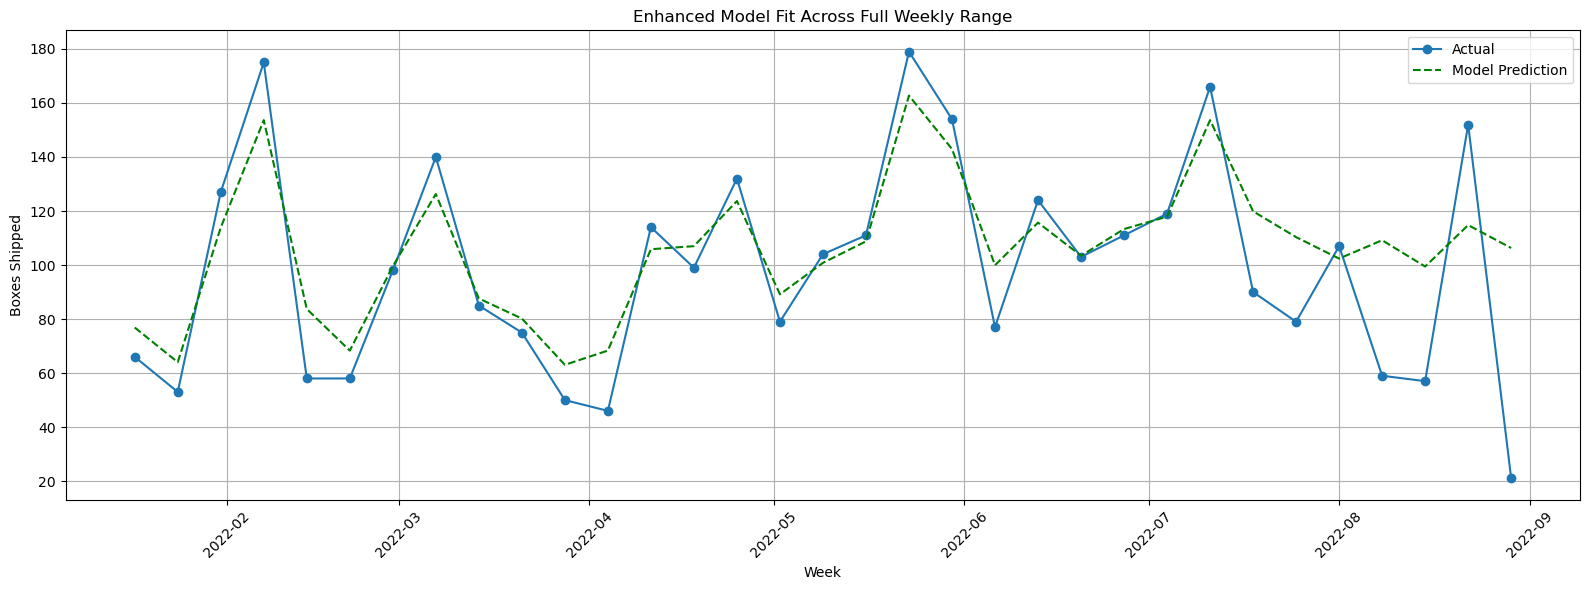

In [86]:
plt.figure(figsize=(16, 6))
plt.plot(weekly_df['Week'], weekly_df['Boxes Shipped'], label='Actual', marker='o')
full_pred = rf_enh.predict(X_enhanced)
plt.plot(weekly_df['Week'], full_pred, label='Model Prediction', linestyle='--', color='green')
plt.xlabel('Week')
plt.ylabel('Boxes Shipped')
plt.title('Enhanced Model Fit Across Full Weekly Range')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

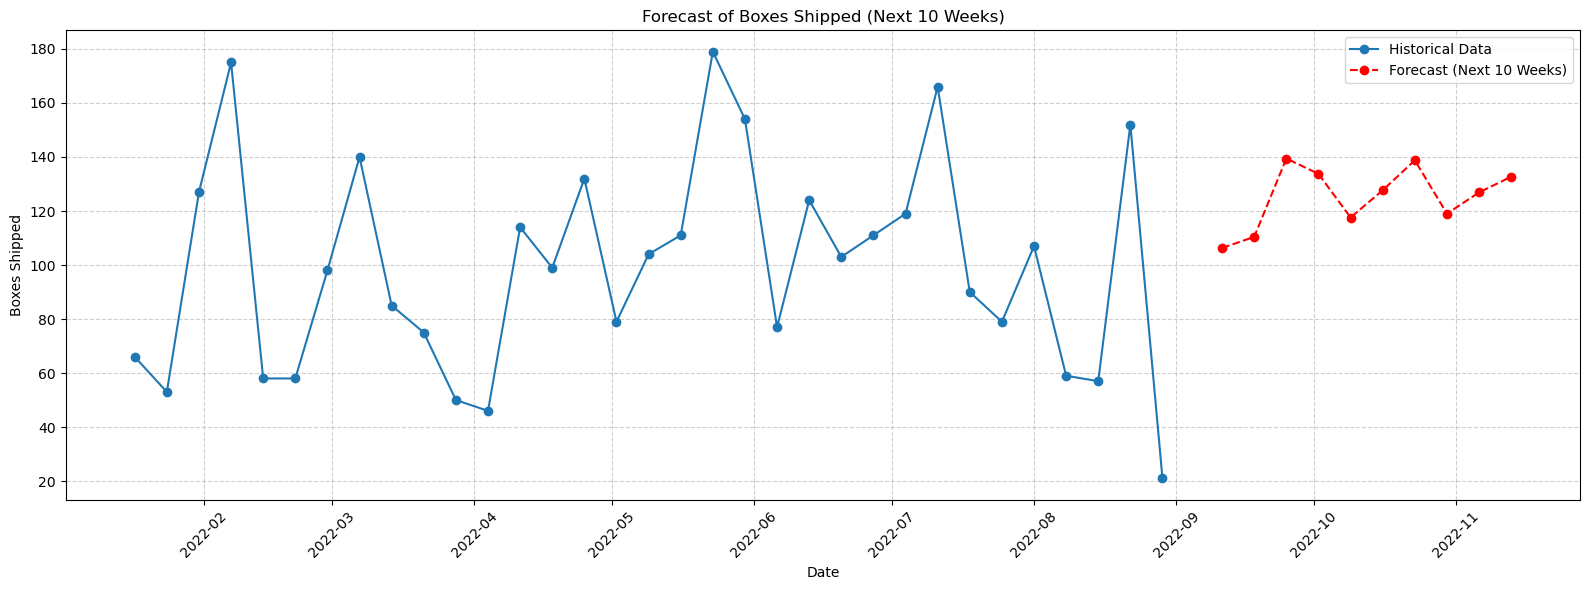

In [88]:
# Forecasting Future Shipments
horizon = 10
future_preds = []
last_features = weekly_df[features].iloc[-1:].copy()

for i in range(horizon):
    pred = rf_enh.predict(last_features)[0]
    future_preds.append(pred)

    next_features = {
        'lag_1': pred,
        'lag_2': last_features['lag_1'].values[0],
        'lag_3': last_features['lag_2'].values[0],
        'rolling_mean_3': np.mean([pred, last_features['lag_1'].values[0], last_features['lag_2'].values[0]]),
        'weekofyear': (last_features['weekofyear'].values[0] + 1) % 52,
        'month': (last_features['month'].values[0] + 1) if last_features['weekofyear'].values[0] == 52 else last_features['month'].values[0]
    }
    last_features = pd.DataFrame([next_features])

forecast_index = pd.date_range(start=weekly_df['Week'].iloc[-1] + pd.Timedelta(weeks=1), periods=horizon, freq='W')
forecast = pd.Series(future_preds, index=forecast_index)

#  Visualization of Forecast
plt.figure(figsize=(16, 6))
plt.plot(weekly_df['Week'], weekly_df['Boxes Shipped'], label='Historical Data', marker='o')
plt.plot(forecast.index, forecast.values, label='Forecast (Next 10 Weeks)', marker='o', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Boxes Shipped')
plt.title('Forecast of Boxes Shipped (Next 10 Weeks)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## End of Notebook

Demonstrated preprocessing, EDA, and forecasting using Random Forest on OTC medication sales data. Future improvements may include trying additional models or fine-tuning parameters.


#  Conclusion

The Random Forest Regressor effectively modeled weekly OTC box shipments and demonstrated strong performance when enhanced with lag-based and calendar features. Compared to the baseline model using only a time index, the enhanced model significantly improved both R² score and mean squared error, confirming the value of incorporating temporal patterns and recent shipment history.

The model captured general trends in the sales data and provided a reliable 10-week forecast, making it a useful tool for inventory planning and early anomaly detection. To further improve forecast accuracy and robustness, future work could include:

- Incorporating external factors (e.g., weather, holidays, flu season)

- Trying alternative models for more comparison

- Applying anomaly detection on model residuals to flag unusual shipment patterns

Overall, the enhanced Random Forest model offers a solid baseline for predictive forecasting and sets the stage for deeper time-series modeling efforts.

